# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [302]:
!pip install gensim==4.0
!pip install plotly


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


Import libraries

In [303]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

# Parameters

I set the parameters of the analysis.

In [304]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [305]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_in

"/Users/barbaramcgillivray/OneDrive - King's College London/Research/2022/Nexus Linguarum WG4 UC4.2/LatinISE"

I define the list of all files:

In [306]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [307]:
len(files)

1146

We only want IntraText files:

In [308]:
files = [f for f in files[:] if "IT" in f]
len(files)

553

I read the metadata file:

In [309]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df

id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  
18                                          Hieronymus   382  poetry  
19                               Ovidius Naso, Publius    -9  poetry  
20                                Benedictus Nursianus   524   prose  
21                             Thomas Aquinas: Sanctus  1254   prose  
22                             Thomas Aquinas: Sanctus  1254  poetry  
..                                                 ...   ...     ...  
683                 Tacitus, Publius (Gaius) Cornelius   116   prose  
684                 Tacitus, Publius (Gaius) Cornelius   116   prose  
685                 Tacitus, Publius (Gaius) Cornelius   116   prose  
686                 Tacitus, Publius (Gaius) Cornelius   116   prose  
687  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose  

[670 rows x 5 columns]

In [310]:
metadata_df.shape

(670, 5)

In [311]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type'], dtype='object')

In [312]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18      382
19       -9
20      524
21     1254
22     1254
       ... 
683     116
684     116
685     116
686     116
687     533
Name: date, Length: 670, dtype: int64>

In [313]:
metadata_df.dtypes

id         object
title      object
creator    object
date        int64
type       object
dtype: object

In [314]:
metadata_df.head

<bound method NDFrame.head of              id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  
18                                          Hieronymus   382  poetry  
19                               Ovidius Naso, Publius    -9  poetry  
20                                Benedictus Nursianus   524   prose  
21                             Thomas Aquinas: Sanctus  1254   prose  
22            

Number of works per year:

In [315]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

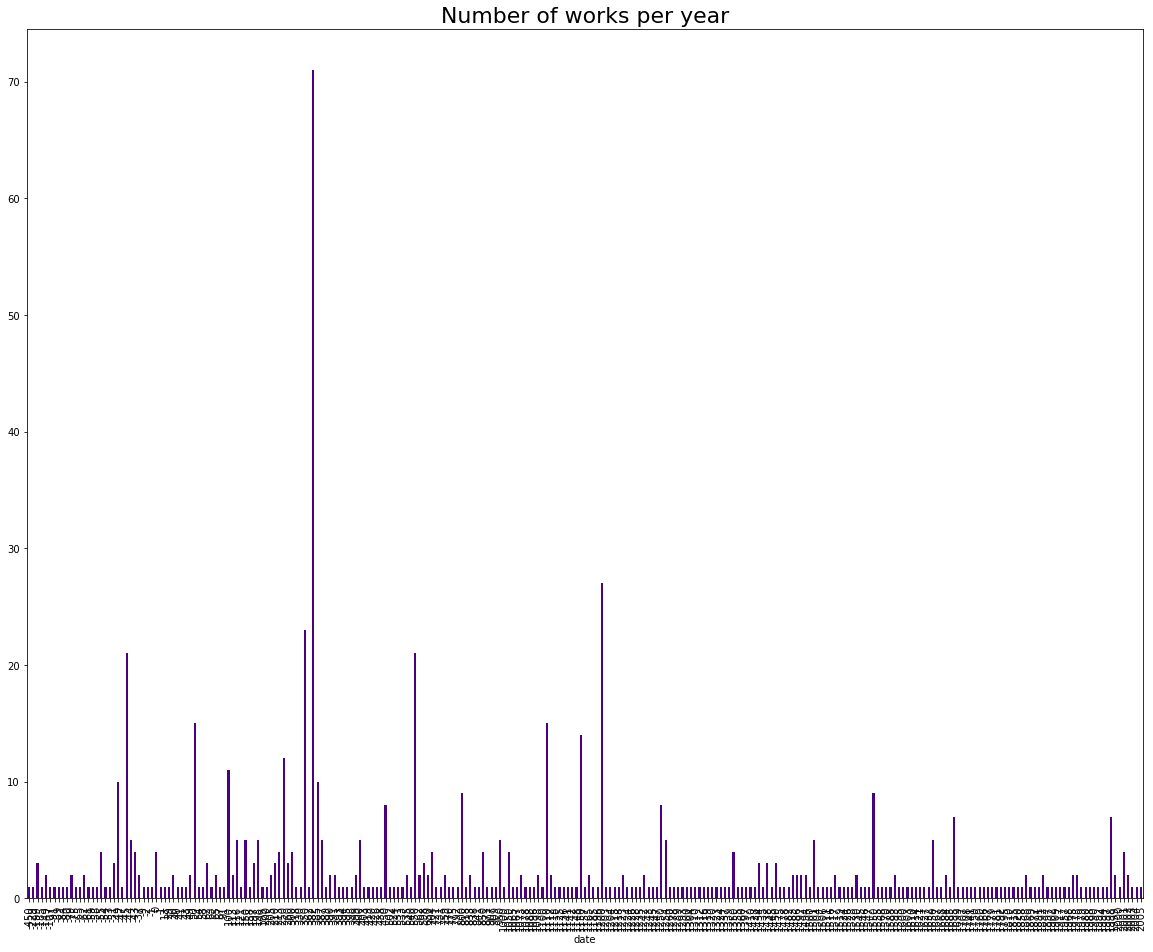

In [316]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora

Find the first and last year in the dataset:

In [317]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


We stop at 900 CE.

In [318]:
last_date = 900

Define size of the time intervals:

In [319]:
size_interval = 450

So there are

In [320]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

3

time intervals.

Define the time periods and split the corpus:

In [321]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900]


Add a column to the metadata_df for the time interval:

In [322]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18     382
23     399
24     391
37     158
38      49
      ... 
682    382
683    116
684    116
685    116
686    116
Name: date, Length: 235, dtype: int64
2
range(450, 900)
20     524
102    800
104    800
105    800
106    800
      ... 
609    598
634    550
636    550
645    450
687    533
Name: date, Length: 73, dtype: int64


id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  \
18                                          Hieronymus   382  poetry   
19                               Ovidius Naso, Publius    -9  poetry   
20                                Benedictus Nursianus   524   prose   
21                             Thomas Aquinas: Sanctus  1254   prose   
22                             Thomas Aquinas: Sanctus  1254  poetry   
..                                                 ...   ...     ...   
683                 Tacitus, Publius (Gaius) Cornelius   116   prose   
684                 Tacitus, Publius (Gaius) Cornelius   116   prose   
685                 Tacitus, Publius (Gaius) Cornelius   116   prose   
686                 Tacitus, Publius (Gaius) Cornelius   116   prose   
687  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

    time_interval  
18              0  
19           -450  
20            450  
21                 
22                 
..            ...  
683             0  
684             0  
685             0  
686             0  
687           450  

[670 rows x 6 columns]

Visualise distribution of time intervals:

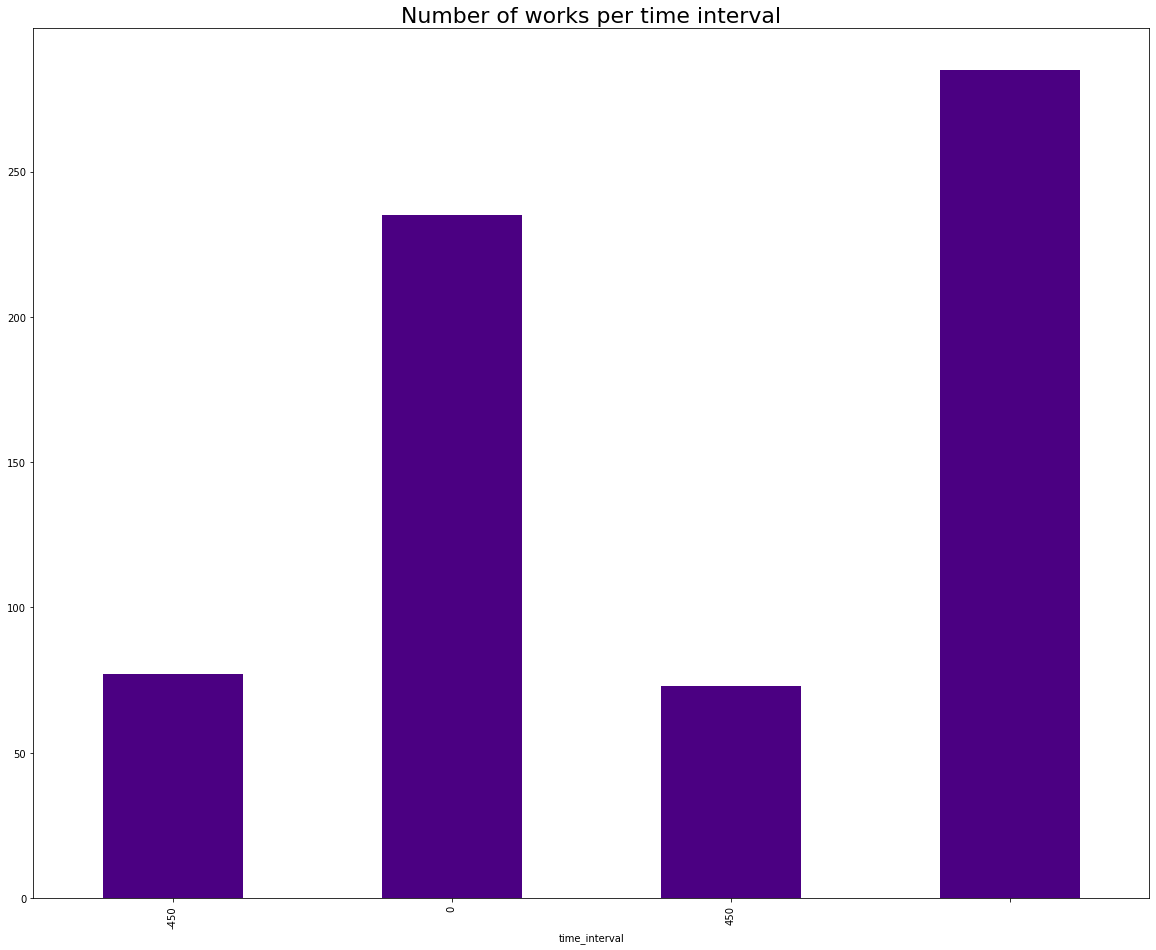

In [323]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

We may want to do something about this inbalance. See further down for the "Historical subcorpus".

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [324]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [325]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [326]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [327]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

In [328]:
metadata_df

id                          title  \
18   IT-LAT0001                        Vulgata   
19   IT-LAT0537                   Ars amatoria   
20   IT-LAT0011            S. Benedicti Regula   
21   IT-LAT0012   In psalmis Davidis expositio   
22   IT-LAT0014                Adoro te devote   
..          ...                            ...   
683  IT-LAT0534  De origine et situ Germanorum   
684  IT-LAT0534        De vita Iulii Agricolae   
685  IT-LAT0534         Dialogus de oratoribus   
686  IT-LAT0534                      Historiae   
687  IT-LAT0202                  Institutiones   

                                               creator  date    type  \
18                                          Hieronymus   382  poetry   
19                               Ovidius Naso, Publius    -9  poetry   
20                                Benedictus Nursianus   524   prose   
21                             Thomas Aquinas: Sanctus  1254   prose   
22                             Thomas Aquinas: Sanctus  1254  poetry   
..                                                 ...   ...     ...   
683                 Tacitus, Publius (Gaius) Cornelius   116   prose   
684                 Tacitus, Publius (Gaius) Cornelius   116   prose   
685                 Tacitus, Publius (Gaius) Cornelius   116   prose   
686                 Tacitus, Publius (Gaius) Cornelius   116   prose   
687  Iustinianus, Caesar Flavius (Imperator Iustini...   533   prose   

    time_interval  
18              0  
19           -450  
20            450  
21                 
22                 
..            ...  
683             0  
684             0  
685             0  
686             0  
687           450  

[670 rows x 6 columns]

In [329]:
corpus

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

In [330]:
len(corpus)

472967

Function for training FastText models (from Krzysztof Nowak):

In [331]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [332]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(30957213, 41518410)

Let's see what words are similar to "dies":

In [333]:
model.wv.similar_by_word('dies', 10)

[('annus', 0.6763132810592651),
 ('hora', 0.6649831533432007),
 ('meridies', 0.6337627172470093),
 ('mensis', 0.6330363154411316),
 ('mensium', 0.609816312789917),
 ('triduum', 0.595200777053833),
 ('quadragesima', 0.5928108096122742),
 ('nox', 0.5850918292999268),
 ('ann', 0.5763802528381348),
 ('quadriduum', 0.5684290528297424)]

Let's try with different parameters:

In [334]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 342 seconds


[('diesim', 0.9257774949073792),
 ('indies', 0.8445021510124207),
 ('meridies', 0.7599064707756042),
 ('diescit', 0.7596815228462219),
 ('octies', 0.7198370695114136),
 ('novies', 0.7172131538391113),
 ('hora', 0.7081755995750427),
 ('diesque', 0.7008793354034424),
 ('mensis', 0.6870858073234558),
 ('sexies', 0.6729897260665894)]

In [335]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 617 seconds


[('diesim', 0.937214732170105),
 ('indies', 0.8582037091255188),
 ('diescit', 0.7800778746604919),
 ('meridies', 0.7678779363632202),
 ('octies', 0.7265893220901489),
 ('diesque', 0.7265809178352356),
 ('hora', 0.7192993760108948),
 ('novies', 0.713594913482666),
 ('diecula', 0.670626699924469),
 ('sexies', 0.6698524951934814)]

I experiment with two equivalent ways to train a Fast Text model:

In [336]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(30957213, 41518410)

In [337]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

472967

In [338]:
np.allclose(model.wv['dies'], model2.wv['dies'])

True

The models has a vocabulary of

In [339]:
model.corpus_total_words

8303682

words and 

In [340]:
model.corpus_count

472967

sentences.

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [341]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    #print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


Let's inspect the corpus for the first time interval:

In [342]:
time2corpus[0]

[['ars',
  'amatorius',
  'Siquis',
  'in',
  'hic',
  'ars',
  'populus',
  'non',
  'nosco',
  'amo',
  'hic',
  'lego#2',
  'et',
  'lectus',
  'carmen',
  'doceo',
  'amo'],
 ['ars',
  'cieo',
  'veloque',
  'rates',
  'remoque',
  'moveo',
  'ars',
  'levis',
  'currus',
  'ars',
  'rego',
  'amor'],
 ['currus',
  'Automedon',
  'lentisque',
  'sum',
  'aptus',
  'habena',
  'Tiphys',
  'in',
  'Haemonia',
  'puppe',
  'magister',
  'sum',
  'ego',
  'Venus',
  'artifex',
  'tener',
  'praeficio',
  'amor',
  'Tiphys',
  'et',
  'Automedon',
  'dico#2',
  'amor',
  'ego'],
 ['ille',
  'quidem',
  'ferus',
  'sum',
  'et',
  'quis#2',
  'ego',
  'saepe',
  'repugno',
  'sed',
  'puer',
  'sum',
  'aetas',
  'mollis',
  'et',
  'aptus',
  'rex'],
 ['Phillyrides',
  'puer',
  'cithara',
  'perficio',
  'Achillem',
  'atque',
  'animus',
  'placidus',
  'contundo',
  'ars',
  'ferus'],
 ['qui',
  'totiens',
  'socius',
  'totiens',
  'exterruit',
  'hostis',
  'credo',
  'annosus',
  

And the second:

In [343]:
time2corpus[1]

[['magnus',
  'sum',
  'dominus',
  'et',
  'laudabilis',
  'valde',
  'magnus',
  'virtus',
  'tuus',
  'et',
  'sapientia',
  'tuus',
  'non',
  'sum',
  'numerus'],
 ['et',
  'laudo',
  'tu',
  'volo#1',
  'homo',
  'aliquis',
  'portio',
  'creatura',
  'tuus',
  'et',
  'homo',
  'circumfero',
  'mortalitem',
  'suus',
  'circumfero',
  'testimonium',
  'peccatum',
  'suus',
  'et',
  'testimonium',
  'quia',
  'superbus',
  'resisto',
  'et',
  'tamen',
  'laudo',
  'tu',
  'volo#1',
  'homo',
  'aliquis',
  'portio',
  'creatura',
  'tuus'],
 ['tuuus',
  'excito',
  'ut',
  'laudo',
  'tu',
  'delecto',
  'quia',
  'facio',
  'nos',
  'ad',
  'tu',
  'et',
  'inquies',
  'sum',
  'cor',
  'noster',
  'donec',
  'requiesco',
  'in',
  'tu'],
 ['do',
  'ego',
  'dominus',
  'scio',
  'et',
  'intellego',
  'utrum',
  'sum',
  'prius',
  'invoco',
  'tu',
  'an',
  'laudo',
  'tu',
  'et',
  'scio',
  'tu',
  'prius',
  'sum',
  'an',
  'invoco',
  'tu'],
 ['sed', 'quis#2', 'tu', '

And the third:

In [344]:
time2corpus[2]

[['obsculta',
  'o',
  'filius',
  'praeceptum',
  'magister',
  'et',
  'inclino',
  'auris',
  'cor',
  'tuus',
  'et',
  'admonitio',
  'pius',
  'pater',
  'libet',
  'excipe',
  'et',
  'efficaciter',
  'comple',
  'ut',
  'ad',
  'is',
  'per',
  'oboedientia',
  'labor',
  'redeo',
  'ab',
  'quo',
  'per',
  'inoboedientia',
  'desidia',
  'recedo'],
 ['ad',
  'tu',
  'ergo',
  'nunc',
  'ego',
  'sermo',
  'dirigo',
  'quisquis',
  'abrenuntio',
  'proprius',
  'voluntas',
  'dominus',
  'Christus',
  'verus',
  'rex',
  'militaturus',
  'oboedientia',
  'fortis',
  'atque',
  'praeclarus',
  'arma',
  'sumo'],
 ['in',
  'primus',
  'ut',
  'quisquis',
  'ago',
  'inchoas',
  'bonus',
  'ab',
  'is',
  'perficio',
  'instantissima',
  'oratio',
  'deposco',
  'ut',
  'quis#2',
  'nos',
  'iam',
  'in',
  'filius',
  'dignor',
  'sum',
  'numerus',
  'computo',
  'non',
  'debeo',
  'aliquando',
  'de',
  'malus',
  'actus',
  'noster',
  'contristo'],
 ['ita',
  'enim',
  'is'

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

Start with the first subcorpus:

In [345]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 43 seconds


[('meridies', 0.8839325904846191),
 ('abies', 0.8018586039543152),
 ('rabies', 0.770072877407074),
 ('diesque', 0.6955942511558533),
 ('pontes', 0.6926696300506592),
 ('annuum', 0.6887799501419067),
 ('planities', 0.6662036180496216),
 ('progenies', 0.6468406915664673),
 ('facies', 0.6464639902114868),
 ('tempus', 0.6286655068397522)]

In [346]:
print_vocab(model, 10)

word #0/9743 is sum
word #1/9743 is et
word #2/9743 is in
word #3/9743 is quis#2
word #4/9743 is is
word #5/9743 is cum
word #6/9743 is ad
word #7/9743 is ut
word #8/9743 is hic


I now check the similar words to "sum":

In [347]:
model.wv.similar_by_word('sum', 10)

[('adsum', 0.811521053314209),
 ('sumne', 0.7608218193054199),
 ('asum', 0.7598937749862671),
 ('ausum', 0.7449746131896973),
 ('desum', 0.732574999332428),
 ('sumo', 0.722877025604248),
 ('Salsum', 0.6937724351882935),
 ('dorsum', 0.6853122115135193),
 ('deorsum', 0.6852438449859619),
 ('Thapsum', 0.6834602952003479)]

The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms) 

Let's try changing the parameters to exclude subwords:

In [348]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 8 seconds


[('annus', 0.7173142433166504),
 ('hora', 0.6179774403572083),
 ('biennium', 0.6023102402687073),
 ('tempus', 0.599920928478241),
 ('mensis', 0.5940921306610107),
 ('paulum', 0.5812205076217651),
 ('vigilia', 0.5790657997131348),
 ('triduum', 0.5681582689285278),
 ('biduum', 0.560013473033905),
 ('nox', 0.5495080947875977)]

Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms:

In [349]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

It has taken 7 seconds


[('biduum', 0.6206176280975342),
 ('annus', 0.6122283339500427),
 ('hora', 0.6081395149230957),
 ('triduum', 0.5757302641868591),
 ('mensis', 0.56607586145401),
 ('biennium', 0.5388177037239075),
 ('tempus', 0.5205956697463989),
 ('nox', 0.5039001107215881),
 ('paulum', 0.4976813793182373),
 ('bis', 0.4681026339530945)]

In [350]:
model.wv.similar_by_word('sum', 10)

[('habeo', 0.583010196685791),
 ('propterea', 0.43986791372299194),
 ('fio', 0.4252910614013672),
 ('desum', 0.4181338846683502),
 ('pario', 0.4177384674549103),
 ('indigeo', 0.41432151198387146),
 ('ignoro', 0.4105473458766937),
 ('intersum', 0.406978577375412),
 ('etenim', 0.40656864643096924),
 ('perfectus', 0.404587060213089)]

I now train one model for each time interval:

In [351]:
len(time2corpus)

4

In [352]:
models = list()
start = time.time()
for t in range(len(time2corpus)):
    if len(time2corpus[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0)  # instantiate
        model.build_vocab(corpus_iterable=time2corpus[t])
        model.train(corpus_iterable=time2corpus[t], total_examples=len(time2corpus[t]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
2
It has taken 54 seconds, or  1 minutes


Let's check some models:

In [353]:
print_vocab(models[0], 20)

word #0/2328 is sum
word #1/2328 is et
word #2/2328 is in
word #3/2328 is quis#2
word #4/2328 is is
word #5/2328 is cum
word #6/2328 is ad
word #7/2328 is ut
word #8/2328 is hic
word #9/2328 is non
word #10/2328 is ab
word #11/2328 is omnis
word #12/2328 is quod
word #13/2328 is atque
word #14/2328 is res
word #15/2328 is ex
word #16/2328 is se
word #17/2328 is si
word #18/2328 is quam#4


In [354]:
models[0].wv.similar_by_word('dies', 10)

[('biduum', 0.5964162945747375),
 ('triduum', 0.5598636269569397),
 ('annus', 0.5150065422058105),
 ('hora', 0.5050020217895508),
 ('mensis', 0.4783902168273926),
 ('biennium', 0.47501885890960693),
 ('nox', 0.42553049325942993),
 ('Martius', 0.4083157777786255),
 ('vigilia', 0.4080023467540741),
 ('pridie', 0.39923080801963806)]

In [355]:
print_vocab(models[1], 20)

word #0/4425 is et
word #1/4425 is sum
word #2/4425 is in
word #3/4425 is quis#2
word #4/4425 is is
word #5/4425 is non
word #6/4425 is hic
word #7/4425 is ut
word #8/4425 is cum
word #9/4425 is ad
word #10/4425 is quod
word #11/4425 is ab
word #12/4425 is si
word #13/4425 is sed
word #14/4425 is ille
word #15/4425 is atque
word #16/4425 is ex
word #17/4425 is omnis
word #18/4425 is se


In [356]:
models[1].wv.similar_by_word('dies', 10)

[('hora', 0.7012492418289185),
 ('feriae', 0.5686432123184204),
 ('annus', 0.5483298897743225),
 ('mane', 0.48769691586494446),
 ('quadragesimus', 0.4875779151916504),
 ('biduum', 0.48581477999687195),
 ('Kalendae', 0.48354512453079224),
 ('ianuarius', 0.47882336378097534),
 ('nonus', 0.4627411365509033),
 ('undecimus', 0.46149078011512756)]

In [357]:
models[2].wv.similar_by_word('dies', 10)

[('mensa', 0.5813192129135132),
 ('septimana', 0.5781058073043823),
 ('hora', 0.5778090953826904),
 ('mensis', 0.5657422542572021),
 ('annus', 0.5632498860359192),
 ('nox', 0.534672737121582),
 ('luna', 0.523279070854187),
 ('pascha', 0.5161781311035156),
 ('biennium', 0.5028867721557617),
 ('quintus', 0.4989112317562103)]

##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:



In [358]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    print(common_vocab)
    print(m1)
    print(m2)
    return (common_vocab, m1, m2)

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [359]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    common_vocab, in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


Now I can apply the function to my models:

In [360]:
smart_procrustes_align_gensim(models[2], models[0])

1453 1453
1453 1453
['sum', 'et', 'in', 'quis#2', 'is', 'ab', 'non', 'ad', 'hic', 'cum', 'ut', 'si', 'quod', 'omnis', 'ex', 'suus', 'se', 'de', 'atque', 'sed', 'ille', 'ipse', 'res', 'facio', 'dico#2', 'possum', 'quam#4', 'aut', 'vel', 'imperator', 'per', 'qui', 'habeo', 'alius', 'autem', 'multus', "'", 'nec', 'enim', 'etiam', 'video', 'idem', 'ego', 'verus', 'rex', 'Romanus', 'do', 'causa', 'tu', 'tempus', 'locus', 'ita', 'unus', 'magnus', 'dies', 'pars', 'noster', 'ne#2', 'pro', 'primus', 'quo', 'modus', 'neque', 'venio', 'homo', 'annus', 'tamen', 'quidem', 'D', 'iam', 'deus', 'post', 'consul', 'bonus', '-', 'bellum', 'urbs', 'nullus', 'nos', 'pater', 'nihil', 'quia', 'quidam', 'tuus', 'aliquis', 'tantus', 'filius', 'lex', 'inter', 'hostis', 'publicus', 'ago', 'accipio', 'exercitus', 'sive', 'animus', 'nomen', 'quoque', 'vir', 'fio', 'ante', 'duo', 'debeo', 'mitto', 'vos', 'tum', 'nisi', 'sine', 'civitas', 'ubi', 'castrum', 'vis', 'contra', 'genus', 'parvus', 'miles', 'jus', 'volo#1'

I align all models:

In [361]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

1450 1450
1450 1450
['sum', 'et', 'in', 'quis#2', 'is', 'non', 'hic', 'ut', 'cum', 'ad', 'ab', 'quod', 'si', 'sed', 'ex', 'ille', 'omnis', 'atque', 'se', 'suus', 'ipse', 'de', 'dico#2', 'quam#4', 'possum', 'facio', 'aut', 'res', 'per', 'alius', 'nec', 'etiam', 'multus', 'habeo', 'enim', 'vel', 'ego', 'qui', 'video', 'autem', 'idem', "'", 'deus', 'ne#2', 'quo', 'tu', 'verus', 'do', 'magnus', 'ita', 'homo', 'pars', 'tamen', 'iam', 'locus', 'primus', 'unus', 'modus', 'dies', 'neque', 'quoque', 'quidam', 'quidem', 'rex', 'nos', 'causa', 'tempus', 'bonus', 'pro', 'inter', 'noster', 'bellum', 'Romanus', 'pater', 'nihil', '-', 'imperator', 'quia', 'tantus', 'venio', 'post', 'nullus', 'aliquis', 'filius', 'nomen', 'animus', 'ago', 'urbs', 'corpus', 'annus', 'fio', 'debeo', 'nisi', 'publicus', 'tuus', 'ubi', 'sine', 'sic', 'parvus', 'apud', 'ante', 'meus', 'duo', 'verbum', 'miles', 'iste', 'genus', 'accipio', 'solus', 'volo#1', 'namque', 'vir', 'exercitus', 'tum', 'alter', 'mitto', 'nunc', 'hos

Now the models have been aligned and have the same vocabulary:

In [362]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

0 1450
1 1450
2 1450


# Semantic change with cosine similarity

In [363]:
intervals

[-450, 0, 450, 900]

In [364]:
models

I define a function that, given a reference step (either "first" or "last), it returns the time intervals' range to be used to compare models against this reference step:

In [365]:
def find_reference_intervals(reference_step, intervals):
    
    if reference_step == "first":
        #range_intervals = range(intervals[1], intervals[len(intervals)-1], size_interval)
        #range_intervals_index = range(1, len(intervals)-1)
        #reference_interval = intervals[0]
        reference_interval_index = 0
    elif reference_step == "last":
        #range_intervals = range(intervals[0], intervals[len(intervals)-2], size_interval)
        #range_intervals_index = range(0, len(intervals)-2)
        #reference_interval = intervals[len(intervals)-1]
        reference_interval_index = len(intervals)-2
        
    #return (range_intervals, range_intervals_index, reference_interval, reference_interval_index)
    return reference_interval_index

In [366]:
find_reference_intervals("first", intervals)

0

In [367]:
find_reference_intervals("last", intervals)

2

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the reference time interval:

In [368]:
def cosine_similarity(word, t, reference_step, models, intervals):
    #(range_intervals, range_intervals_index, reference_interval, reference_interval_index)= find_reference_intervals(reference_step)
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    sc = np.nan
    if models[reference_interval_index] == '':
        print("Model of reference interval is empty!")
    else:
        if models[t] != '':
            #print(t, word)
            sc = 1-spatial.distance.cosine(models[t].wv[word], models[reference_interval_index].wv[word])
    return sc

In [369]:
cosine_similarity("sum", 2, "last", models, intervals)

1.0

In [370]:
cosine_similarity("sum", 2, "first", models, intervals)

0.38232070207595825

Now I define a function that, given a reference step and a time interval index (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two time inetrvals, and stores this in the dataframe cosine_similarity_df:

In [371]:
def cosine_similarity_dataframe(reference_step, time_interval_index, models, intervals):
    if time_interval_index<0 or time_interval_index>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    #print(reference_interval_index)
    if models[reference_interval_index] != '' and models[time_interval_index] != '':
        cosine_similarity_df = pd.DataFrame(([w, 
            models[reference_interval_index].wv.get_vecattr(w, "count"),
            models[time_interval_index].wv.get_vecattr(w, "count"),
            cosine_similarity(w,time_interval_index, reference_step, models, intervals)  
            ] for w in models[time_interval_index].wv.index_to_key), 
        columns = ('Word', "Frequency_t_reference-"+str(reference_step), "Frequency_t"+str(time_interval_index), 
        'Cosine_similarity(w_t_reference-'+str(reference_step)+',w_t'+str(time_interval_index)+')'))
    else:
        print("The reference model or the current model are empty!")
        cosine_similarity_df = pd.DataFrame()
    return cosine_similarity_df

In [372]:
cosine_similarity_dataframe("last", 0, models, intervals)

Word  Frequency_t_reference-last  Frequency_t0  \
0           sum                       39802         42712   
1            et                       32552         29469   
2            in                       22659         26200   
3        quis#2                       22190         24571   
4            is                       19987         21063   
...         ...                         ...           ...   
1445       ovis                         103            98   
1446      ditio                         104            97   
1447     edoceo                         100            97   
1448  quindecim                         101            97   
1449   molestia                         100            97   

      Cosine_similarity(w_t_reference-last,w_t0)  
0                                       0.382321  
1                                       0.184685  
2                                       0.309014  
3                                       0.288552  
4                                       0.290869  
...                                          ...  
1445                                    0.071220  
1446                                    0.176303  
1447                                    0.098868  
1448                                    0.185793  
1449                                    0.263372  

[1450 rows x 4 columns]

In [373]:
cosine_similarity_dataframe("last", 1, models, intervals)

Word  Frequency_t_reference-last  Frequency_t1  \
0          sum                       39802         77405   
1           et                       32552         73396   
2           in                       22659         47830   
3       quis#2                       22190         46322   
4           is                       19987         30529   
...        ...                         ...           ...   
1445   annalis                         100           222   
1446  molestia                         100           221   
1447    edoceo                         100           221   
1448   incurro                         100           221   
1449  largitio                         100           221   

      Cosine_similarity(w_t_reference-last,w_t1)  
0                                       0.761296  
1                                       0.695578  
2                                       0.814093  
3                                       0.793260  
4                                       0.733539  
...                                          ...  
1445                                    0.260013  
1446                                    0.448690  
1447                                    0.413718  
1448                                    0.456983  
1449                                    0.357133  

[1450 rows x 4 columns]

Visualise the distribution of the semantic similarity scores with a histogram:

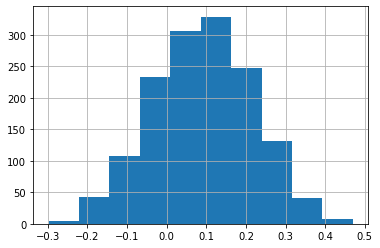

In [374]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0, models, intervals).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [88]:
intervals

[-450, 0, 450, 900]

In [300]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
for i in range(len(models)-1):
    #print(reference_interval_index)
    #print("Interval", str(range_intervals[i]))
    #print((list(range_intervals)))
    print("Interval", str(intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models, intervals)
    if i == 0:
        time_series_df = df
        col_i = "interval-"+str(0)
        time_series_df[col_i] = [0 for w in models[reference_interval_index].wv.index_to_key]
        col_n = "neighbours_ref-"+reference_step
        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
    else:
        #time_series_df = time_series_df, df.iloc[:,-2:]
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(tmp_df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
        
    #print(time_series_df)
    
time_series_df

Interval -450 with 450
Interval 0 with 450


Word  Frequency_t_reference-last  Frequency_t0  \
0           sum                       39802         42712   
1            et                       32552         29469   
2            in                       22659         26200   
3        quis#2                       22190         24571   
4            is                       19987         21063   
...         ...                         ...           ...   
1445       ovis                         103            98   
1446      ditio                         104            97   
1447     edoceo                         100            97   
1448  quindecim                         101            97   
1449   molestia                         100            97   

      Cosine_similarity(w_t_reference-last,w_t0)  interval-0  \
0                                       0.382321           0   
1                                       0.184685           0   
2                                       0.309014           0   
3                                       0.288552           0   
4                                       0.290869           0   
...                                          ...         ...   
1445                                    0.071220           0   
1446                                    0.176303           0   
1447                                    0.098868           0   
1448                                    0.185793           0   
1449                                    0.263372           0   

                                    neighbours_ref-last  Frequency_t1  \
0     [(consisto, 0.43683284521102905), (nomino, 0.3...         77405   
1     [(autem, 0.3554714620113373), (quoque, 0.32455...         73396   
2     [(de, 0.4198196828365326), (super, 0.419617414...         47830   
3     [(quod, 0.6590680480003357), (quos, 0.65775090...         46322   
4     [(hereditas, 0.49811914563179016), (scilicet, ...         30529   
...                                                 ...           ...   
1445  [(biennium, 0.6993876099586487), (spatium, 0.6...           222   
1446  [(discrimen, 0.5735316872596741), (consumo, 0....           221   
1447  [(doctrina, 0.6243841052055359), (disco, 0.573...           221   
1448  [(appeto, 0.677386999130249), (perdo, 0.627718...           221   
1449  [(aurum, 0.6340999603271484), (praetorius, 0.6...           221   

      Cosine_similarity(w_t_reference-last,w_t1)  interval-1  \
0                                       0.761296           1   
1                                       0.695578           1   
2                                       0.814093           1   
3                                       0.793260           1   
4                                       0.733539           1   
...                                          ...         ...   
1445                                    0.260013           1   
1446                                    0.448690           1   
1447                                    0.413718           1   
1448                                    0.456983           1   
1449                                    0.357133           1   

                                          neighbours_t1  
0     [(accido#2, 0.5070229172706604), (appareo, 0.4...  
1     [(atque, 0.43450120091438293), (praeditus, 0.4...  
2     [(circa, 0.45825448632240295), (ad, 0.40748164...  
3     [(quod, 0.6889013051986694), (quos, 0.55848264...  
4     [(hic, 0.4166969656944275), (actio, 0.40328374...  
...                                                 ...  
1445  [(liber#4, 0.6997617483139038), (Paulus, 0.627...  
1446  [(desiderium, 0.5416098833084106), (peccatum, ...  
1447  [(declaro, 0.5543445348739624), (cano, 0.47305...  
1448  [(vexo, 0.6034849882125854), (premo, 0.5647425...  
1449  [(odium, 0.4948987662792206), (privo, 0.480133...  

[1450 rows x 10 columns]

In [301]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'neighbours_ref-last', 'Frequency_t1',
       'Cosine_similarity(w_t_reference-last,w_t1)', 'interval-1',
       'neighbours_t1'],
      dtype='object')

In [94]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

interval-0  Cosine_similarity(w_t_reference-last,w_t0)
0              0                                    0.382321
1              0                                    0.184685
2              0                                    0.309014
3              0                                    0.288552
4              0                                    0.290869
...          ...                                         ...
1445           0                                    0.071220
1446           0                                    0.176303
1447           0                                    0.098868
1448           0                                    0.185793
1449           0                                    0.263372

[1450 rows x 2 columns]

In [95]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

<bound method NDFrame.describe of       interval-0  Cosine_similarity(w_t_reference-last,w_t0)
0              0                                    0.382321
1              0                                    0.184685
2              0                                    0.309014
3              0                                    0.288552
4              0                                    0.290869
...          ...                                         ...
1445           0                                    0.071220
1446           0                                    0.176303
1447           0                                    0.098868
1448           0                                    0.185793
1449           0                                    0.263372

[1450 rows x 2 columns]>

In [96]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

interval-1  Cosine_similarity(w_t_reference-last,w_t1)
0              1                                    0.761296
1              1                                    0.695578
2              1                                    0.814093
3              1                                    0.793260
4              1                                    0.733539
...          ...                                         ...
1445           1                                    0.260013
1446           1                                    0.448690
1447           1                                    0.413718
1448           1                                    0.456983
1449           1                                    0.357133

[1450 rows x 2 columns]

In [100]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
               ]].iloc[0]

Cosine_similarity(w_t_reference-last,w_t0)    0.382321
Cosine_similarity(w_t_reference-last,w_t1)    0.761296
Name: 0, dtype: float64

In [101]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

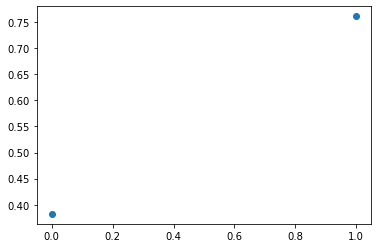

In [105]:
plt.scatter([0,1], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [106]:
time_series_df.columns

Index(['Word', 'Frequency_t_reference-last', 'Frequency_t0',
       'Cosine_similarity(w_t_reference-last,w_t0)', 'interval-0',
       'neighbours_ref-last', 'Frequency_t1',
       'Cosine_similarity(w_t_reference-last,w_t1)', 'interval-1',
       'neighbours_t1'],
      dtype='object')

In [299]:
time_series_df

Empty DataFrame
Columns: []
Index: []

In [111]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1

Time_interval Cosine_sim       Word
0              0   0.382321        sum
0              1   0.761296        sum
0              0   0.184685         et
0              1   0.695578         et
0              0   0.309014         in
..           ...        ...        ...
0              1   0.413718     edoceo
0              0   0.185793  quindecim
0              1   0.456983  quindecim
0              0   0.263372   molestia
0              1   0.357133   molestia

[2900 rows x 3 columns]

List of socio-political terms:

In [112]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [298]:
time_series_df_socpol = time_series_df[time_series_df['Word'].isin(socio_political_terms)]
time_series_df_socpol

KeyError: 'Word'

In [114]:
time_series_df1_socpol = time_series_df1[time_series_df1['Word'].isin(socio_political_terms)]
time_series_df1_socpol

Time_interval Cosine_sim       Word
0             0  -0.036925  imperator
0             1   0.699319  imperator
0             0   0.077728       urbs
0             1   0.623431       urbs
0             0   0.021672     hostis
0             1    0.53906     hostis
0             0   0.111718     consul
0             1    0.55814     consul
0             0   0.130162    civitas
0             1   0.624839    civitas
0             0   0.124582    senatus
0             1   0.690409    senatus
0             0    0.24059    populus
0             1   0.639801    populus
0             0   0.030366        jus
0             1   0.581212        jus
0             0  -0.007295  consilium
0             1   0.688584  consilium
0             0   -0.08757        dux
0             1    0.33827        dux
0             0    0.01815       gens
0             1   0.710663       gens
0             0   0.046846     regnum
0             1   0.643188     regnum
0             0   0.102445   potestas
0             1   0.490804   potestas
0             0   0.307709      labor
0             1    0.54958      labor
0             0   0.146675      natio
0             1   0.551543      natio
0             0   0.211127   pontifex
0             1   0.769486   pontifex

In [126]:
time_series_df_socpol.dtypes

Time_interval    object
Cosine_sim       object
Word             object
dtype: object

I'll fix the data types of the columns:

In [128]:
time_series_df_socpol["Time_interval"] = pd.to_numeric(time_series_df_socpol["Time_interval"], downcast='integer')

<ipython-input-128-b782da5ac154>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:
time_series_df_socpol["Cosine_sim"] = pd.to_numeric(time_series_df_socpol["Cosine_sim"], downcast='float')

<ipython-input-130-18253f88ede1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



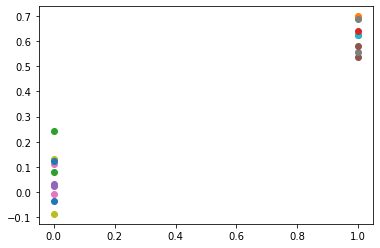

In [131]:
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df_socpol[['Time_interval']].iloc[i], 
            time_series_df_socpol[['Cosine_sim']].iloc[i])
plt.show()

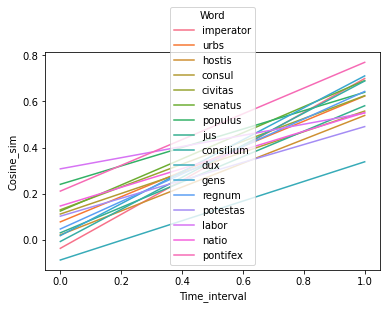

In [139]:
import seaborn as sns
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df_socpol, hue='Word', legend="full")
plt.show()

## Historical subcorpus

I select by time period before 800CE and historical genre:

In [141]:
selected_texts = ['LAT0142', 'LAT0241', 'LAT0529', 'LAT0172', 'LAT0123', 'LAT0134', 'LAT0849', 'LAT0148', 'LAT0325', 'LAT0278', 'LAT1040', 'LAT1042', 'LAT0111', 'LAT0054', 'LAT0201', 'LAT0896', 'LAT0959', 'LAT0115', 'LAT0612', 'LAT0776', 'LAT0850', 'LAT0886', 'LAT0121', 'LAT0726', 'LAT0878', 'LAT0768', 'LAT0410', 'LAT0791', 'LAT0196', 'LAT0906', 'LAT0783', 'LAT0909']
selected_texts = ['IT-'+f for f in selected_texts]
selected_texts

['IT-LAT0142',
 'IT-LAT0241',
 'IT-LAT0529',
 'IT-LAT0172',
 'IT-LAT0123',
 'IT-LAT0134',
 'IT-LAT0849',
 'IT-LAT0148',
 'IT-LAT0325',
 'IT-LAT0278',
 'IT-LAT1040',
 'IT-LAT1042',
 'IT-LAT0111',
 'IT-LAT0054',
 'IT-LAT0201',
 'IT-LAT0896',
 'IT-LAT0959',
 'IT-LAT0115',
 'IT-LAT0612',
 'IT-LAT0776',
 'IT-LAT0850',
 'IT-LAT0886',
 'IT-LAT0121',
 'IT-LAT0726',
 'IT-LAT0878',
 'IT-LAT0768',
 'IT-LAT0410',
 'IT-LAT0791',
 'IT-LAT0196',
 'IT-LAT0906',
 'IT-LAT0783',
 'IT-LAT0909']

In [175]:
len(selected_texts)

32

In [142]:
#metadata_df_sel = pd.read_csv(os.path.join(dir_in, 'Metadata_selected_corpus.csv'), sep = ",")
#metadata_df_sel = metadata_df_sel[(metadata_df_sel['Selected for our study (1 or 0)'] == 1)
#                          & (metadata_df_sel['historical texts'] == 1)]
metadata_df_sel  = metadata_df[(metadata_df['id'].isin(selected_texts))]
metadata_df_sel.shape

(27, 6)

In [143]:
metadata_df_sel

id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type time_interval  
41               Svetonius Tranquillus, Caius   121  prose             0  
69           Plinius Gaius, Cecilius Secundus   100  prose             0  
72                                  Eutropius   350  prose             0  
78                       Ammianus Marcellinus   362  prose             0  
89                     Cicero, Marcus Tullius   -55  prose          -450  
97                              Livius, Titus    -1  prose          -450  
98                 Velleius Paterculus, Caius    29  prose             0  
118                                  Iordanes   550  prose           450  
120                 Iustinus Iunianus, Marcus   250  prose             0  
142                         [Auctor incertus]   -49  prose          -450  
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose             0  
182                    Curtius Rufus, Quintus    50  prose             0  
236                        Severus, Sulpicius   403  prose             0  
382                        Severus, Sulpicius   350  prose             0  
451                                Hieronymus   390  prose             0  
472                      Augustinus, Aurelius   419  prose             0  
478                       Hydatius Lemicensis   350  prose             0  
482                      Gregorius Turonensis   550  prose           450  
490                         Marcellinus Comes   550  prose           450  
535                     Actorius Naso, Marcus   -49  prose          -450  
536        Auctor incertus (Aurelius Victor?)   350  prose             0  
551                                Hieronymus   400  prose             0  
557                                  Ablabius   330  prose             0  
563              Gargilius Martialis, Quintus   260  prose             0  
572                                  Iordanes   550  prose           450  
575            Isidorus Hispalensis Episcopus   598  prose           450  
611                     Cor

Define size of the time intervals:

In [254]:
size_interval = 450

So there are

In [255]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

3

time intervals.

In [256]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900]


Add a column to the metadata_df for the time interval:

In [257]:
metadata_df_sel['time_interval'] = ""
for t in range(len(intervals)-1):
    #print(t)
    #print(range(intervals[t],intervals[t+1]))
    metadata_df_sel_t = metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1]))]
    #print(metadata_df_sel_t.date)
    metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
    #print(intervals[t])
metadata_df_sel

<ipython-input-257-fdf9a07fb554>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type time_interval  
41               Svetonius Tranquillus, Caius   121  prose             0  
69           Plinius Gaius, Cecilius Secundus   100  prose             0  
72                                  Eutropius   350  prose             0  
78                       Ammianus Marcellinus   362  prose             0  
89                     Cicero, Marcus Tullius   -55  prose          -450  
97                              Livius, Titus    -1  prose          -450  
98                 Velleius Paterculus, Caius    29  prose             0  
118                                  Iordanes   550  prose           450  
120                 Iustinus Iunianus, Marcus   250  prose             0  
142                         [Auctor incertus]   -49  prose          -450  
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose             0  
182                    Curtius Rufus, Quintus    50  prose             0  
236                        Severus, Sulpicius   403  prose             0  
382                        Severus, Sulpicius   350  prose             0  
451                                Hieronymus   390  prose             0  
472                      Augustinus, Aurelius   419  prose             0  
478                       Hydatius Lemicensis   350  prose             0  
482                      Gregorius Turonensis   550  prose           450  
490                         Marcellinus Comes   550  prose           450  
535                     Actorius Naso, Marcus   -49  prose          -450  
536        Auctor incertus (Aurelius Victor?)   350  prose             0  
551                                Hieronymus   400  prose             0  
557                                  Ablabius   330  prose             0  
563              Gargilius Martialis, Quintus   260  prose             0  
572                                  Iordanes   550  prose           450  
575            Isidorus Hispalensis Episcopus   598  prose           450  
611                     Cor

In [258]:
metadata_df_sel.describe

<bound method NDFrame.describe of              id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et c

Visualise distribution of time intervals:

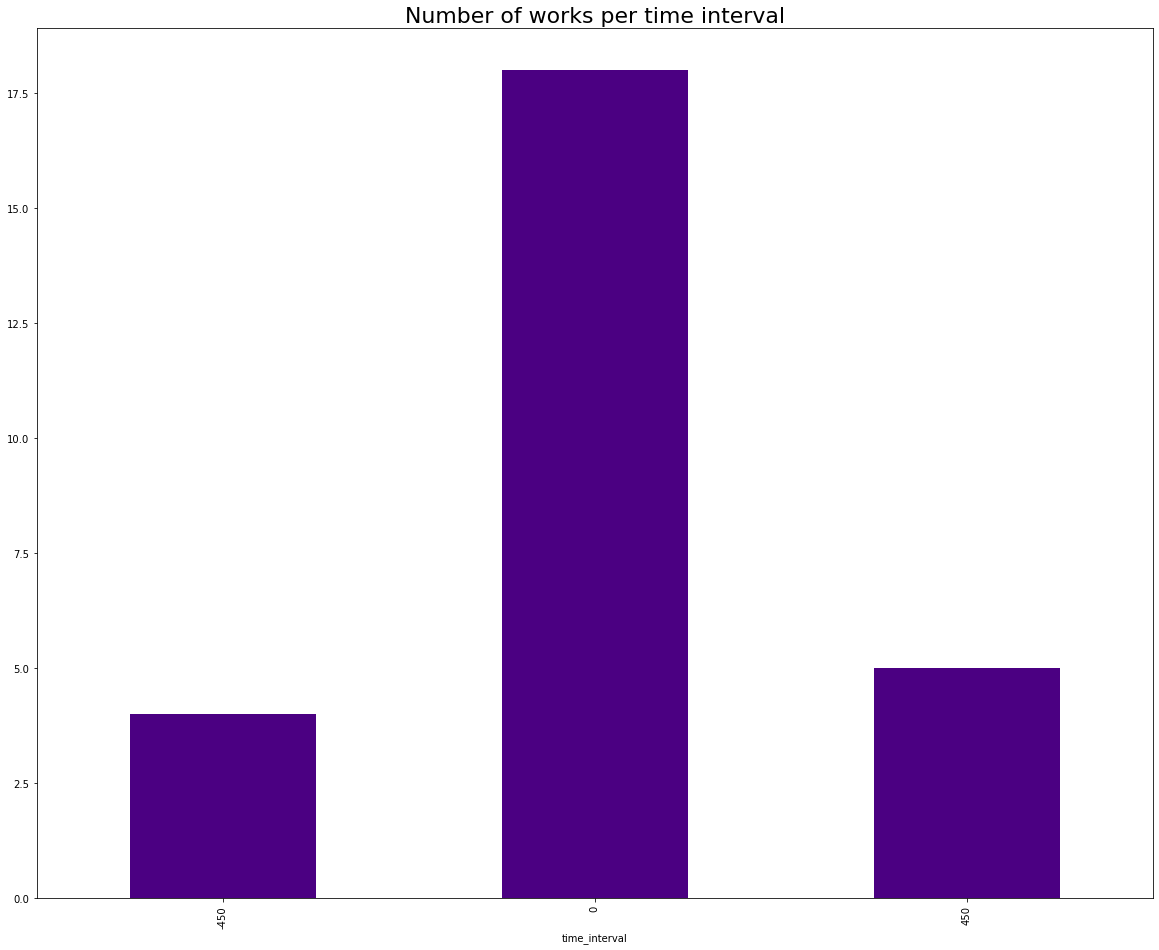

In [259]:
metadata_df0_sel = metadata_df_sel.groupby(['time_interval']).count()
metadata_df0_sel = metadata_df0_sel['id']
metadata_df0_sel
ax = metadata_df0_sel.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

There are:

In [260]:
n_intervals_sel = round((max(metadata_df_sel['time_interval'])-min(metadata_df_sel['time_interval']))/size_interval)
n_intervals_sel

2

in the historical subcorpus.

## Training embeddings for the whole subcorpus

#### Stopwords exclusion and further filtering


I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [261]:
corpus_sel = list()
files_corpus_sel = metadata_df_sel
for index, df_line in files_corpus_sel.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus_sel.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus_sel.append(sentences_this_file)

In [262]:
corpus_sel

[['vita',
  'DIVI',
  'IVLI',
  'annus',
  'agens',
  'sextus',
  'decimus',
  'pater',
  'amitto',
  'sequentibusque',
  'consul',
  'flamen',
  'Dialis',
  'destinatus',
  'dimitto',
  'Cossutius',
  'quis#2',
  'familia',
  'equester',
  'sed',
  'admodum',
  'dives',
  'praetextatus',
  'desponsor',
  'sum',
  'Cornelius',
  'Cinna',
  'quater',
  'consul',
  'filia',
  'duco',
  'uxor',
  'ex',
  'qui',
  'ille',
  'mox',
  'Iulia',
  'nascor',
  'sum',
  'neque',
  'ut',
  'repudio',
  'compelli',
  'ab',
  'dictator',
  'Sulla',
  'ullus',
  'modus',
  'possum'],
 ['quare',
  'et',
  'sacerdotium',
  'et',
  'uxor',
  'dos',
  'et',
  'gentilicis',
  'hereditas',
  'multo',
  'diuersarum',
  'pars',
  'habeo',
  'ut',
  'etiam',
  'discedo',
  'ex',
  'medius',
  'et',
  'quamquam',
  'morbus',
  'quartana',
  'adgrauante',
  'prope',
  'per',
  'singulus',
  'nox',
  'commuto',
  'latebra',
  'cogo',
  'se',
  'ab',
  'inquisitoribus',
  'pecunia',
  'redimo',
  'donec',
  'per

In [263]:
metadata_df_sel

id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et confessoris   
382  IT-LAT0612                                           Chronica   
451  IT-LAT0726                        Vita Malchi monachi captivi   
472  IT-LAT0768                            A Firmo de civitate Dei   
478  IT-LAT0776                                          Chronicon   
482  IT-LAT0783                                          Historiae   
490  IT-LAT0791                                          Chronicon   
535  IT-LAT0849                                Historica fragmenta   
536  IT-LAT0850                   De viris illustribus urbis Romae   
551  IT-LAT0878                                         Vita Pauli   
557  IT-LAT0886           Epistulae de iure civitatis Orcistenorum   
563  IT-LAT0896                              Vita Alexandri Severi   
572  IT-LAT0906  De summa temporum vel origine actibusque genti...   
575  IT-LAT0909  Historia de regibus Gothorum, Vandalorum et Su...   
611  IT-LAT0959                                              Vitae   

                                      creator  date   type time_interval  
41               Svetonius Tranquillus, Caius   121  prose             0  
69           Plinius Gaius, Cecilius Secundus   100  prose             0  
72                                  Eutropius   350  prose             0  
78                       Ammianus Marcellinus   362  prose             0  
89                     Cicero, Marcus Tullius   -55  prose          -450  
97                              Livius, Titus    -1  prose          -450  
98                 Velleius Paterculus, Caius    29  prose             0  
118                                  Iordanes   550  prose           450  
120                 Iustinus Iunianus, Marcus   250  prose             0  
142                         [Auctor incertus]   -49  prose          -450  
166  Augustus, Gaius Iulius Caesar Octavianus    13  prose             0  
182                    Curtius Rufus, Quintus    50  prose             0  
236                        Severus, Sulpicius   403  prose             0  
382                        Severus, Sulpicius   350  prose             0  
451                                Hieronymus   390  prose             0  
472                      Augustinus, Aurelius   419  prose             0  
478                       Hydatius Lemicensis   350  prose             0  
482                      Gregorius Turonensis   550  prose           450  
490                         Marcellinus Comes   550  prose           450  
535                     Actorius Naso, Marcus   -49  prose          -450  
536        Auctor incertus (Aurelius Victor?)   350  prose             0  
551                                Hieronymus   400  prose             0  
557                                  Ablabius   330  prose             0  
563              Gargilius Martialis, Quintus   260  prose             0  
572                                  Iordanes   550  prose           450  
575            Isidorus Hispalensis Episcopus   598  prose           450  
611                     Cor

In [264]:
metadata_df_sel.shape

(27, 6)

In [265]:
metadata_df_sel.describe

<bound method NDFrame.describe of              id                                              title  \
41   IT-LAT0054                                     Vitae Caesarum   
69   IT-LAT0111                                Panegyricus Traiano   
72   IT-LAT0115                         Breviarium ab Urbe condita   
78   IT-LAT0121                               Rerum gestarum Libri   
89   IT-LAT0134                         De provinciis consularibus   
97   IT-LAT0142                                    Ab Urbe condita   
98   IT-LAT0148                                    Historia Romana   
118  IT-LAT0196                      De origine actibusque Getarum   
120  IT-LAT0201     Epitome Historiarum Philippicarum Pompei Trogi   
142  IT-LAT0241                                    De bello Africo   
166  IT-LAT0278                                         Res gestae   
182  IT-LAT0325                Historiarum Alexandri Magni libri X   
236  IT-LAT0410        Vita Sancti Martini episcopi et c

Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [266]:
start = time.time()
model_sel = FastText(vector_size=100, alpha=0.025, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0, 
                  sentences=corpus_sel)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 6 seconds


Let's see what words are similar to "dies":

In [267]:
model_sel.wv.similar_by_word('dies', 10)

[('mensis', 0.6049410700798035),
 ('hora', 0.5926052331924438),
 ('annus', 0.5913792848587036),
 ('biduum', 0.5825180411338806),
 ('tempus', 0.5558829307556152),
 ('triduum', 0.5434627532958984),
 ('nox', 0.5276942253112793),
 ('vigilia', 0.5214745402336121),
 ('biennium', 0.4909501075744629),
 ('triennium', 0.46804842352867126)]

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [268]:
intervals_sel = [None]*(n_intervals_sel+1)
for t in range(n_intervals_sel+1):
    print(t)
    if t == 0:
        intervals_sel[t] = min(metadata_df_sel['time_interval'])
    else:
        intervals_sel[t] = intervals_sel[t-1]+size_interval
    print(intervals_sel[t])
    
print(intervals_sel)

0
-450
1
0
2
450
[-450, 0, 450]


In [269]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus_sel = dict()

# I loop over all time intervals:
for t in range(n_intervals_sel+1):
    files_corpus_sel_t = metadata_df_sel.loc[metadata_df_sel['time_interval'] == intervals_sel[t]]
    print("1:",t, intervals_sel[t], "\n", files_corpus_sel_t, type(files_corpus_t))
    corpus_sel_t = list()
    for index, df_line in files_corpus_sel_t.iterrows():
        print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_sel_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus_sel[t] = corpus_sel_t


1: 0 -450 
              id                       title                 creator  date  \
89   IT-LAT0134  De provinciis consularibus  Cicero, Marcus Tullius   -55   
97   IT-LAT0142             Ab Urbe condita           Livius, Titus    -1   
142  IT-LAT0241             De bello Africo       [Auctor incertus]   -49   
535  IT-LAT0849         Historica fragmenta   Actorius Naso, Marcus   -49   

      type time_interval  
89   prose          -450  
97   prose          -450  
142  prose          -450  
535  prose          -450   <class 'pandas.core.frame.DataFrame'>
line: IT-LAT0134 -450
line: IT-LAT0142 -450
line: IT-LAT0241 -450
line: IT-LAT0849 -450
1: 1 0 
              id                                           title  \
41   IT-LAT0054                                  Vitae Caesarum   
69   IT-LAT0111                             Panegyricus Traiano   
72   IT-LAT0115                      Breviarium ab Urbe condita   
78   IT-LAT0121                            Rerum gestarum Libri 

In [270]:
time2corpus_sel

{0: [['de',
   'provincia',
   'consularis',
   'si',
   'quis#2',
   'vos',
   'pater',
   'conscribo',
   'exspecto',
   'quis#2',
   'sum',
   'provincia',
   'decerno',
   'considero',
   'ipse',
   'se',
   'cum',
   'quis#2',
   'ego',
   'homo',
   'ex',
   'provincia',
   'potissimus',
   'detraho',
   'sum',
   'non',
   'dubito',
   'quis#2',
   'sentio',
   'ego',
   'convenio',
   'cum',
   'quis#2',
   'ego',
   'sentio',
   'necesse',
   'sum',
   'cogitarit'],
  ['atque',
   'si',
   'princeps',
   'is',
   'sententia',
   'dico',
   'laudo',
   'profecto',
   'si',
   'solus',
   'certus',
   'ignosceritis',
   'etiamsi',
   'paulum',
   'parvus',
   'utilis',
   'vos',
   'sententia',
   'video',
   'venio',
   'tamen',
   'aliquis',
   'dolor',
   'meus',
   'tribuo'],
  ['nunc',
   'verus',
   'pater',
   'conscribo',
   'non',
   'parvus',
   'adficior',
   'voluptas',
   'vel',
   'quod',
   'hic',
   'multus',
   'reus',
   'publicus',
   'conduco',
   'Syria',
  

Let's inspect the corpus for the first time interval:

In [271]:
time2corpus_sel[0]

[['de',
  'provincia',
  'consularis',
  'si',
  'quis#2',
  'vos',
  'pater',
  'conscribo',
  'exspecto',
  'quis#2',
  'sum',
  'provincia',
  'decerno',
  'considero',
  'ipse',
  'se',
  'cum',
  'quis#2',
  'ego',
  'homo',
  'ex',
  'provincia',
  'potissimus',
  'detraho',
  'sum',
  'non',
  'dubito',
  'quis#2',
  'sentio',
  'ego',
  'convenio',
  'cum',
  'quis#2',
  'ego',
  'sentio',
  'necesse',
  'sum',
  'cogitarit'],
 ['atque',
  'si',
  'princeps',
  'is',
  'sententia',
  'dico',
  'laudo',
  'profecto',
  'si',
  'solus',
  'certus',
  'ignosceritis',
  'etiamsi',
  'paulum',
  'parvus',
  'utilis',
  'vos',
  'sententia',
  'video',
  'venio',
  'tamen',
  'aliquis',
  'dolor',
  'meus',
  'tribuo'],
 ['nunc',
  'verus',
  'pater',
  'conscribo',
  'non',
  'parvus',
  'adficior',
  'voluptas',
  'vel',
  'quod',
  'hic',
  'multus',
  'reus',
  'publicus',
  'conduco',
  'Syria',
  'Macedoniamque',
  'decerni',
  'ut',
  'dolor',
  'meus',
  'nihil',
  'ab',
  'c

And the second:

In [272]:
time2corpus_sel[1]

[['vita',
  'DIVI',
  'IVLI',
  'annus',
  'agens',
  'sextus',
  'decimus',
  'pater',
  'amitto',
  'sequentibusque',
  'consul',
  'flamen',
  'Dialis',
  'destinatus',
  'dimitto',
  'Cossutius',
  'quis#2',
  'familia',
  'equester',
  'sed',
  'admodum',
  'dives',
  'praetextatus',
  'desponsor',
  'sum',
  'Cornelius',
  'Cinna',
  'quater',
  'consul',
  'filia',
  'duco',
  'uxor',
  'ex',
  'qui',
  'ille',
  'mox',
  'Iulia',
  'nascor',
  'sum',
  'neque',
  'ut',
  'repudio',
  'compelli',
  'ab',
  'dictator',
  'Sulla',
  'ullus',
  'modus',
  'possum'],
 ['quare',
  'et',
  'sacerdotium',
  'et',
  'uxor',
  'dos',
  'et',
  'gentilicis',
  'hereditas',
  'multo',
  'diuersarum',
  'pars',
  'habeo',
  'ut',
  'etiam',
  'discedo',
  'ex',
  'medius',
  'et',
  'quamquam',
  'morbus',
  'quartana',
  'adgrauante',
  'prope',
  'per',
  'singulus',
  'nox',
  'commuto',
  'latebra',
  'cogo',
  'se',
  'ab',
  'inquisitoribus',
  'pecunia',
  'redimo',
  'donec',
  'per

And another one:

In [273]:
time2corpus_sel[7]

KeyError: 7

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

In [274]:
len(time2corpus_sel)

3

In [275]:
models_sel = list()
start = time.time()
for t in range(len(time2corpus_sel)):
    if len(time2corpus_sel[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model_sel = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash, max_n=0)  # instantiate
        model_sel.build_vocab(corpus_iterable=time2corpus_sel[t])
        model_sel.train(corpus_iterable=time2corpus_sel[t], total_examples=len(time2corpus_sel[t]), epochs=10)  # train
        models_sel.append(model_sel)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
    else:
        models_sel.append("")
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

0
1
2
It has taken 14 seconds, or  0 minutes


Let's check some models:

In [276]:
print_vocab(models_sel[0], 20)

word #0/6014 is sum
word #1/6014 is et
word #2/6014 is in
word #3/6014 is is
word #4/6014 is quis#2
word #5/6014 is ad
word #6/6014 is cum
word #7/6014 is ab
word #8/6014 is ut
word #9/6014 is se
word #10/6014 is Romanus
word #11/6014 is non
word #12/6014 is omnis
word #13/6014 is atque
word #14/6014 is ex
word #15/6014 is consul
word #16/6014 is hic
word #17/6014 is quam#4
word #18/6014 is res


In [277]:
print_vocab(models_sel[3], 20)

IndexError: list index out of range

In [278]:
models_sel[0].wv.similar_by_word('dies', 10)

[('biduum', 0.6354857683181763),
 ('triduum', 0.5842409729957581),
 ('pridie', 0.5243738889694214),
 ('hora', 0.5241562724113464),
 ('mensis', 0.5080401301383972),
 ('annus', 0.49982401728630066),
 ('nox', 0.48723697662353516),
 ('quadriduum', 0.4473240375518799),
 ('Martius', 0.441005140542984),
 ('vigilia', 0.4406137466430664)]

In [280]:
models_sel[1].wv.similar_by_word('dies', 10)

[('tempus', 0.7508634924888611),
 ('hora', 0.7424014806747437),
 ('mensis', 0.7025602459907532),
 ('annus', 0.685369074344635),
 ('nox', 0.6431726217269897),
 ('lux', 0.6423462629318237),
 ('ferus', 0.6390551924705505),
 ('sextus', 0.5956592559814453),
 ('decimus', 0.5868772268295288),
 ('locus', 0.5754101276397705)]

In [282]:
models_sel[2].wv.similar_by_word('dies', 10)

[('obeo', 0.8541459441184998),
 ('tempus', 0.8477442860603333),
 ('post', 0.839339017868042),
 ('Catianus', 0.8379827737808228),
 ('Salvius', 0.833858847618103),
 ('tertius', 0.8306082487106323),
 ('transitus', 0.8259238004684448),
 ('sepelio', 0.8153188228607178),
 ('sextus', 0.8075039386749268),
 ('ante', 0.8039585947990417)]

##  Embedding space alignment

I align all models:

In [283]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models_sel)-1):
    reduce(smart_procrustes_align_gensim, [m for m in models_sel if m != ''])
    

4229 4229
4229 4229
['sum', 'et', 'in', 'quis#2', 'is', 'ad', 'cum', 'ut', 'ab', 'se', 'non', 'hic', 'omnis', 'atque', 'ex', 'quam#4', 'suus', 'Romanus', 'quod', 'ipse', 'per', 'res', 'sed', 'bellum', 'facio', 'rex', 'consul', 'nec', 'hostis', 'possum', 'alius', 'si', 'urbs', 'multus', 'habeo', 'dies', 'ille', 'ne#2', 'aut', 'primus', 'de', 'etiam', 'exercitus', 'iam', 'do', 'magnus', 'miles', 'idem', 'inter', 'castrum', 'quoque', 'mitto', 'video', 'mille', '-', 'ita', 'quo', 'venio', 'senatus', 'annus', 'pars', 'dico#2', 'locus', 'qui', 'deinde', 'unus', 'pater', 'animus', 'inde', 'tempus', 'tum', 'post', 'ante', 'duo', 'tantus', 'legatus', 'pro', 'quidam', 'tamen', 'modus', 'ago', 'imperium', 'ego', 'eques', 'neque', 'publicus', 'capio', 'quidem', 'enim', 'ubi', 'vis', 'nihil', 'populus', 'causa', 'deus', ']', '[', 'accipio', 'Roma', "'", 'nullus', 'dux', 'arma', 'civitas', 'plebs', 'peto', 'homo', 'nomen', 'filius', 'fero', 'ager', 'tribunus', 'acies', 'M.', 'quos', 'verus', 'itaque

Now the models have been aligned and have the same vocabulary:

In [284]:
for i in range(0,len(models_sel)):
    if models_sel[i] != '':
        print(i, len(models_sel[i].wv.index_to_key))

0 2194
1 2194
2 2194


# Semantic change with cosine similarity

In [285]:
intervals_sel

[-450, 0, 450]

In [286]:
models_sel

In [287]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index

1

In [289]:
models_sel[2].wv["sum"]

array([-0.06928699,  0.3097195 , -0.38248476, -0.02655491,  0.2943064 ,
       -0.3248885 ,  0.69706523,  0.39279777, -0.76074684, -0.14185295,
       -0.08946114,  0.0148009 ,  0.10423341,  0.08895415,  0.21928878,
       -0.43668467,  0.38204026, -0.12712343, -0.40739718, -0.5907124 ,
        0.62463313,  0.01407574,  0.363506  ,  0.36510542, -0.33967867,
       -0.28747147, -0.03056896, -0.09324879, -0.25353366, -0.08599543,
        0.09050766, -0.40519056,  0.23553547, -0.12978317, -0.21460864,
        0.1250672 ,  0.31565377, -0.01578123, -0.20215312, -0.43952635,
       -0.05507354,  0.01973756,  0.25072622,  0.13353032,  0.48265293,
        0.46925053, -0.30214998, -0.16191775,  0.38685268, -0.06941959,
        0.2144832 ,  0.07341593,  0.24836826, -0.2128794 ,  0.04955096,
        0.1243349 , -0.3204178 , -0.06189023, -0.43107566, -0.15284532,
        0.32506967,  0.03295948, -0.0297599 , -0.29963502, -0.44693908,
        0.45244914,  0.2460871 ,  0.27572185, -0.33970568,  0.38

In [290]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index
#cosine_similarity("sum", 4, "last", models_sel)

1

In [291]:
cosine_similarity("sum", 2, "first", models_sel, intervals_sel)

0.5421316623687744

In [292]:
models_sel

In [293]:
cosine_similarity_dataframe("last", 0, models_sel, intervals_sel)

Word  Frequency_t_reference-last  Frequency_t0  \
0             sum                       13046         17478   
1              et                        9810         12820   
2              in                        8620         12602   
3          quis#2                        7296          9355   
4              is                        5741          8096   
...           ...                         ...           ...   
2189  providentia                          28            24   
2190       evello                          28            24   
2191        purum                          28            24   
2192     provolvo                          28            24   
2193     excelsum                          28            24   

      Cosine_similarity(w_t_reference-last,w_t0)  
0                                       0.828372  
1                                       0.741417  
2                                       0.773855  
3                                       0.836159  
4                                       0.779520  
...                                          ...  
2189                                    0.882389  
2190                                    0.839376  
2191                                    0.784893  
2192                                    0.917521  
2193                                    0.836383  

[2194 rows x 4 columns]

In [294]:
cosine_similarity_dataframe("first", 2, models_sel, intervals_sel)

Word  Frequency_t_reference-first  Frequency_t2  \
0          sum                        17478          4392   
1           et                        12820          4233   
2           in                        12602          3968   
3       quis#2                         9355          3128   
4           is                         8096          3048   
...        ...                          ...           ...   
2189  provolvo                           24             9   
2190  respergo                           24             9   
2191     assum                           24             9   
2192    surdus                           24             9   
2193  excelsum                           24             9   

      Cosine_similarity(w_t_reference-first,w_t2)  
0                                        0.542132  
1                                        0.452537  
2                                        0.371169  
3                                        0.554354  
4                                        0.590496  
...                                           ...  
2189                                     0.861982  
2190                                     0.890539  
2191                                     0.902139  
2192                                     0.890030  
2193                                     0.831795  

[2194 rows x 4 columns]

Visualise the distribution of the semantic similarity scores with a histogram:

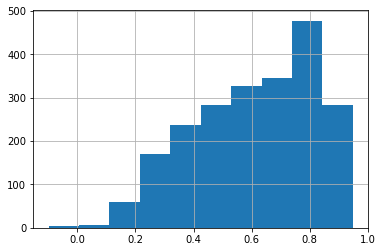

In [296]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("first", 2, models_sel, intervals_sel).iloc[:,-1].hist()